In [1]:
import pandas as pd

df = pd.read_csv("AA.Complete Data.csv")
df = df.drop(columns = ["MW Supply"])
df["DATE & TIME"] = pd.to_datetime(df["DATE & TIME"])

# Create Timestamp As Seconds
df["timestamp"] = df["DATE & TIME"].astype("int64") // 10**9
df= df.drop(columns=["DATE & TIME"])

df = df[["timestamp"] + [col for col in df.columns if col != "timestamp"]]
df.head()

,timestamp,Solar Radiation (Wh/m)2,UV Intensity,Atmospheric Clarity,Temperature (2m),Humidity (2M),PS,Wind Speed (10m),Wind Direction (10m),MW Demand
0,1609459200,0.0,0.0,0.37,8.03,6.65,93.99,3.62,85.05,204.89
1,1609462800,0.0,0.0,0.37,8.01,6.65,94.00,3.50,91.92,191.17
2,1609466400,0.0,0.0,0.37,8.03,6.65,94.00,3.41,98.58,182.21
3,1609470000,0.0,0.0,0.37,8.01,6.59,93.98,3.33,101.65,171.64
4,1609473600,0.0,0.0,0.37,7.92,6.59,93.98,3.26,104.87,168.28


In [2]:
from sklearn.preprocessing import MinMaxScaler

x = df.drop(columns=["MW Demand"])
y = df["MW Demand"].values.reshape(-1, 1)

train_size = int(0.8 * len(x))
val_size = int(0.1 * train_size)

x_train_full, x_test = x[:train_size], x[train_size:]
y_train_full, y_test = y[:train_size], y[train_size:]

x_train, x_val = x_train_full[:-val_size], x_train_full[-val_size:]
y_train, y_val = y_train_full[:-val_size], y_train_full[-val_size:]

x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_val_scaled = x_scaler.transform(x_val)
x_test_scaled = x_scaler.transform(x_test)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_val_scaled = y_scaler.transform(y_val)
y_test_scaled = y_scaler.transform(y_test)

# Print shape to verify
print(f"Training Data:      {x_train.shape}, {y_train.shape}")
print(f"Validation Data:    {x_val.shape}, {y_val.shape}")
print(f"Testing Data:       {x_test.shape}, {y_test.shape}")

Training Data:      (6308, 9), (6308, 1)
Validation Data:    (700, 9), (700, 1)
Testing Data:       (1752, 9), (1752, 1)


In [3]:
import numpy as np
def create_sequence(data, labels, look_back):
    sequences = []
    label_values = []

    # Convert Data to Numpy array
    data = data.values if isinstance(data, pd.DataFrame) else data
    labels = labels.values if isinstance(labels, pd.Series) else labels

    for i in range(len(data) - look_back):
        seq = data[i: i + look_back]  # Collect data for the look-back period
        label = labels[i + look_back]  # The next hour’s value as target

        sequences.append(seq)
        label_values.append(label)

    # Convert to numpy arrays and reshape if needed
    sequences = np.array(sequences, dtype=np.float32)
    label_values = np.array(label_values, dtype=np.float32).reshape(-1, 1)  # Ensure labels are 2D

    return sequences, label_values

look_back = 24  # Past 24 hours

# Create sequences and labels
X_train_seq, y_train_seq = create_sequence(x_train_scaled, y_train_scaled, look_back)
X_val_seq, y_val_seq     = create_sequence(x_val_scaled, y_val_scaled, look_back)
X_test_seq, y_test_seq   = create_sequence(x_test_scaled, y_test_scaled, look_back)

# Ensure the shape is correct for CNN + LSTM hybrid model
print(f"Training    X shape: {X_train_seq.shape} ")
print(f"Training    Y shape: {y_train_seq.shape} ")
print(f"Validation  X shape: {X_val_seq.shape} ")
print(f"Validation  Y shape: {y_val_seq.shape} ")
print(f"Testing     X shape: {X_test_seq.shape} ")
print(f"Testing     Y shape: {y_test_seq.shape}")


Training    X shape: (6284, 24, 9) 
Training    Y shape: (6284, 1) 
Validation  X shape: (676, 24, 9) 
Validation  Y shape: (676, 1) 
Testing     X shape: (1728, 24, 9) 
Testing     Y shape: (1728, 1)


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2

model = Sequential()

model.add(Conv1D(filters=64, kernel_size=5, activation="relu", kernel_regularizer=l2(0.001),input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.4))

model.add(LSTM(units=50, return_sequences=True, kernel_regularizer=l2(1e-4)))
model.add(LSTM(units=16, return_sequences=False, kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.3))

model.add(Dense(10, activation="relu"))
model.add(Dense(1))

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='huber',
    metrics=['mae']
)

In [20]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

LR_scheduler = ReduceLROnPlateau(
    monitor = "val_loss",
    factor = 0.5,
    patience = 3,
    min_lr = 1e-6
)

early_stopping = EarlyStopping(
    monitor = "val_loss",
    patience = 10,
    restore_best_weights = True
)

history = model.fit(
    X_train_seq,
    y_train_seq,
    epochs = 50,
    validation_data = (X_val_seq, y_val_seq),
    callbacks = [LR_scheduler, early_stopping],
)

Epoch 1/50
197/197 [==============================] - 6s 13ms/step - loss: 0.1337 - mae: 0.3729 - val_loss: 0.0371 - val_mae: 0.0903 - lr: 1.0000e-04
Epoch 2/50
197/197 [==============================] - 2s 10ms/step - loss: 0.0492 - mae: 0.1565 - val_loss: 0.0625 - val_mae: 0.2347 - lr: 1.0000e-04
Epoch 3/50
197/197 [==============================] - 2s 11ms/step - loss: 0.0442 - mae: 0.1392 - val_loss: 0.0882 - val_mae: 0.3294 - lr: 1.0000e-04
Epoch 4/50
197/197 [==============================] - 2s 10ms/step - loss: 0.0404 - mae: 0.1266 - val_loss: 0.0772 - val_mae: 0.2988 - lr: 1.0000e-04
Epoch 5/50
197/197 [==============================] - 2s 10ms/step - loss: 0.0386 - mae: 0.1225 - val_loss: 0.0816 - val_mae: 0.3152 - lr: 5.0000e-05
Epoch 6/50
197/197 [==============================] - 2s 11ms/step - loss: 0.0374 - mae: 0.1197 - val_loss: 0.0785 - val_mae: 0.3080 - lr: 5.0000e-05
Epoch 7/50
197/197 [==============================] - 2s 10ms/step - loss: 0.0363 - mae: 0.1151 - va

In [21]:
from sklearn.metrics import mean_absolute_error

# Predict on train, test, val sequences
y_train_pred_scaled = model.predict(X_train_seq)
y_test_pred_scaled = model.predict(X_test_seq)
y_val_pred_scaled = model.predict(X_val_seq)

# Inverse scale predictions and true values
y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled)
y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled)
y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled)

y_train_true = y_scaler.inverse_transform(y_train_seq)
y_test_true = y_scaler.inverse_transform(y_test_seq)
y_val_true = y_scaler.inverse_transform(y_val_seq)

# Calculate MAE for each dataset
mae_train = mean_absolute_error(y_train_true, y_train_pred)
mae_test = mean_absolute_error(y_test_true, y_test_pred)
mae_val = mean_absolute_error(y_val_true, y_val_pred)

# Calculate mean of true values (for relative error)
mean_train = np.mean(y_train_true)
mean_test = np.mean(y_test_true)
mean_val = np.mean(y_val_true)

# Calculate RMAE
rmae_train = mae_train / mean_train
rmae_test = mae_test / mean_test
rmae_val = mae_val / mean_val

print(f"Training RMAE: {rmae_train * 100:.2f}%")
print(f"Validation RMAE: {rmae_val* 100:.2f}%")
print(f"Testing RMAE: {rmae_test * 100:.2f}%")

22/22 [==============================] - 0s 3ms/step
Training RMAE: 21.38%
Validation RMAE: 10.55%
Testing RMAE: 23.89%


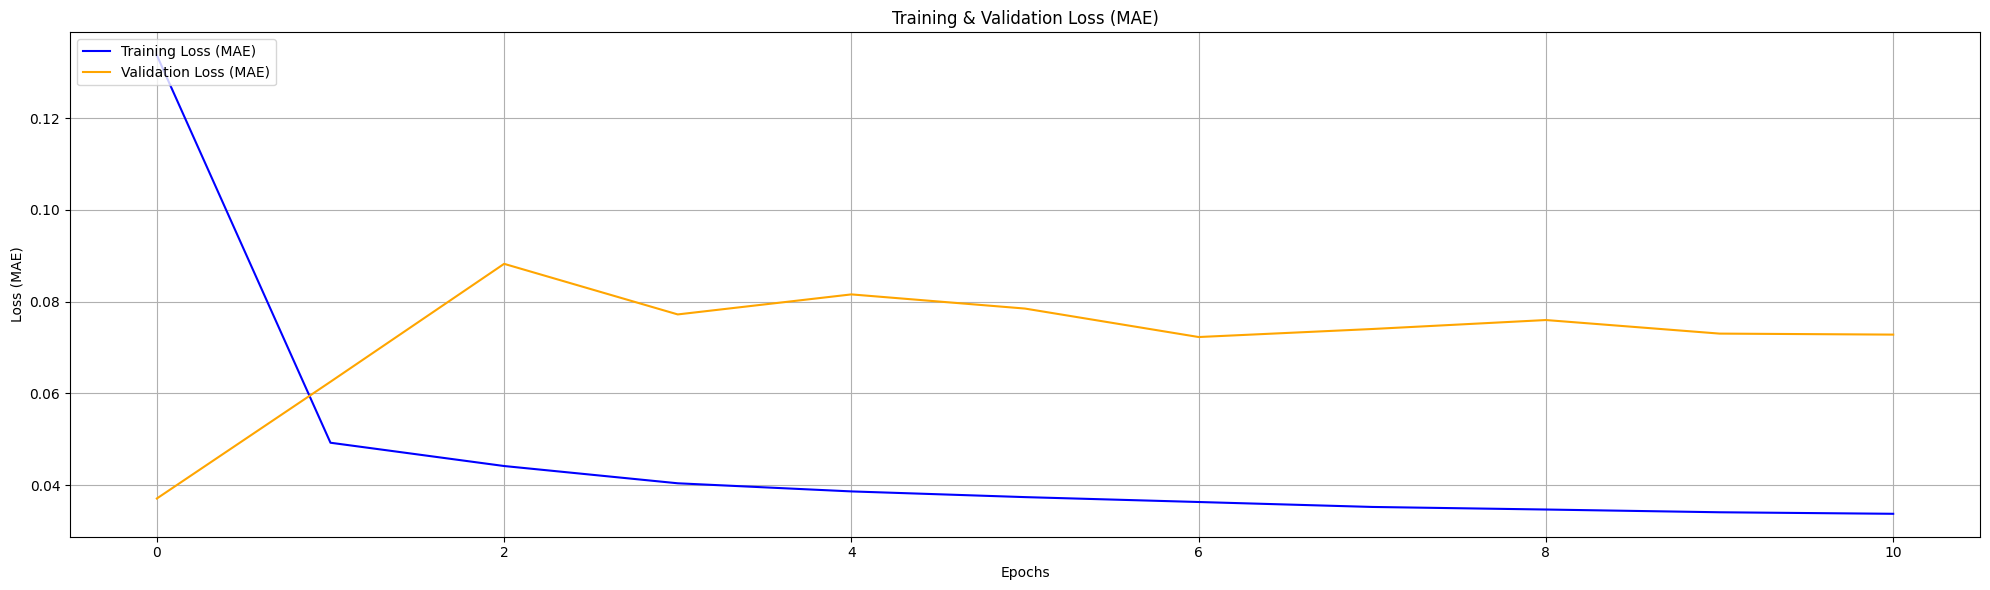

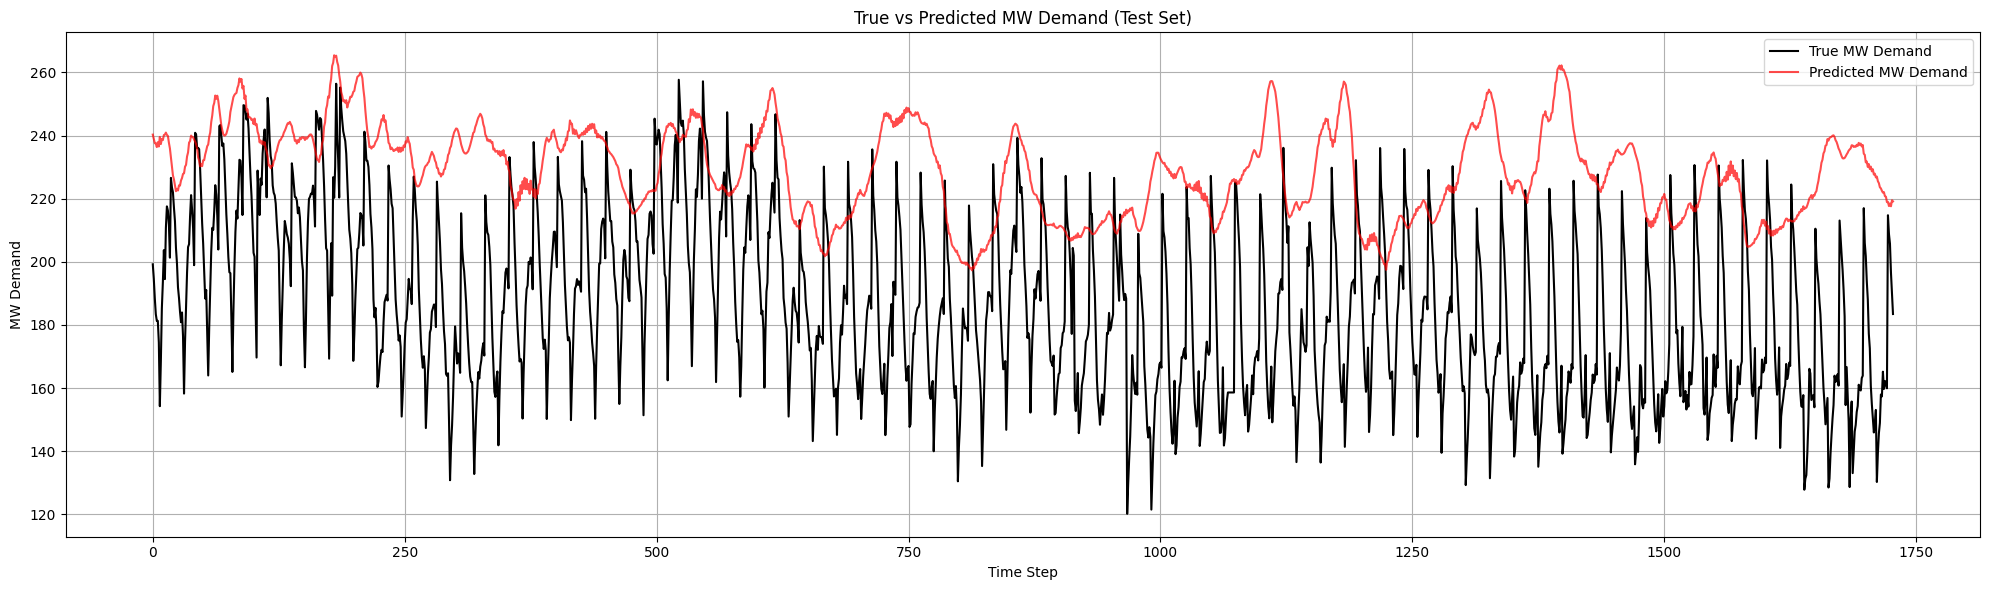

In [22]:
import matplotlib.pyplot as plt

training_loss = history.history["loss"]
val_loss = history.history["val_loss"]
train_rmae = np.sqrt(training_loss)  # RMAE is the square root of the loss (MAE)
val_rmae = np.sqrt(val_loss)  # RMAE for validation

# Plot for Loss
plt.figure(figsize=(20, 6))
plt.plot(training_loss, label="Training Loss (MAE)", color="blue")
plt.plot(val_loss, label="Validation Loss (MAE)", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Loss (MAE)")
plt.title("Training & Validation Loss (MAE)")
plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot True vs Predicted for Test
plt.figure(figsize=(20, 6))
plt.plot(y_test_true, label="True MW Demand", color="black")
plt.plot(y_test_pred, label="Predicted MW Demand", color="red", alpha=0.7)
plt.xlabel("Time Step")
plt.ylabel("MW Demand")
plt.title("True vs Predicted MW Demand (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()